In [86]:
import sys
from abc import ABC, abstractmethod

import numpy as np
from scipy import optimize
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scipy as sp
import scanpy as scp
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
import random
import operator


import pandas as pd
import harmonypy as hm
from time import time
import seaborn as sns
import string

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler

from scipy.io import mmread
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import randomized_svd
import umap
from itertools import permutations

import logging

import anndata



import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

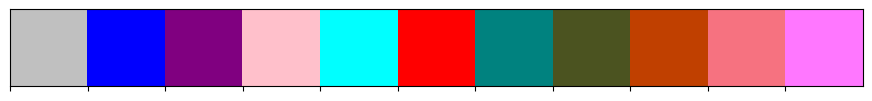

In [87]:
my_favourote_palette = ['#C0C0C0','#0000FF','#800080','#FFC0CB','#00FFFF','#FF0000','#00827F','#4B5320','#C04000','#F67280','#FF77FF']
sns.palplot(sns.color_palette(my_favourote_palette))
customPalette = sns.set_palette(sns.color_palette(my_favourote_palette))

In [88]:
def nearPSD(A,epsilon=0):
   n = A.shape[0]
   eigval, eigvec = np.linalg.eig(A)
   val = np.matrix(np.maximum(eigval,1e-4))
   vec = np.matrix(eigvec)
   T = 1/(np.multiply(vec,vec) * val.T)
   T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
   B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
   out = B*B.T
   return(out)

In [89]:
def invreg(original_matrix, epsilon=1e-3):
    """
    Invert a matrix with regularization to avoid singularity.

    Parameters:
    - original_matrix: Input matrix to be inverted.
    - epsilon: Small value for regularization.

    Returns:
    - inverted_matrix: Inverted matrix.
    """

    # Adding a small diagonal matrix to avoid singularity
    diagonal_matrix = epsilon * np.eye(original_matrix.shape[0])
    regularized_matrix = original_matrix + diagonal_matrix

    # Invert the regularized matrix
    inverted_matrix = np.linalg.inv(regularized_matrix)

    return inverted_matrix

In [90]:
def replace_zeros_with_small_number(array, small_number=1e-30):
    """
    Replace zero values in a NumPy array with a very small number.

    Parameters:
    - array: NumPy array.
    - small_number: The small number to replace zero values with. Default is 1e-10.

    Returns:
    - Modified NumPy array with zero values replaced.
    """
    array[array == 0] = small_number
    return array

# Utils Function

In [91]:
def machineEpsilon(func=float):
    machine_epsilon = func(1)
    while func(1)+func(machine_epsilon) != func(1):
        machine_epsilon_last = machine_epsilon
        machine_epsilon = func(machine_epsilon) / func(2)
    return machine_epsilon_last

In [92]:
# Creates a UMAP visualization of high dimensional data
## Input: Feature set, labels, colors of clusters
## Output: UMAP plot

def umap_visualize(arr, labels, palette="hls"):
    u = umap.UMAP().fit_transform(
        arr
    )
    umap_data = pd.DataFrame({'u0': u[:, 0], 'u1': u[:, 1], 'label': labels})
    sns.scatterplot(data=umap_data, x='u0', y='u1', hue='label', palette=palette)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [93]:
# Obtains misclassicfication error with respect to a given clustering
## Input: number of clusters, true clusters, estimated clusters
## Output: misclassification error

def misclassification_rate(k, sigma, sigmahat):
    # given two clustering of length p sigma(i) in {0, 1, ..., k-1}
    # return their misclassification rate up to permutation
    # k is the number of clusters
    p = len(sigma)
    res = 1
    new_sigma = [0] * p
    for perm in permutations(range(k)):
        for i in range(p):
            new_sigma[i] = perm[sigmahat[i]]
        cur = sum(a != b for a, b in zip(sigma, new_sigma))
        res = min(res, cur/p)
    return res

In [94]:
# Fits K-Means and obtains labels for a set of features
## Input: Feature Matrix, number of clusters
## Output: k means labels

def get_kmeans_label(feature, k = 2):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature)
    kmeans = KMeans(
        init = "random",
        n_clusters = k,
        n_init = 10,
        max_iter = 300,
        random_state = 42
        )
    kmeans.fit(scaled_features)
    return kmeans.labels_

In [95]:
# Computes robust SVD
## Input: Features, number of singular values
## Output: Singular vectors and Values

def robust_svd(arr, n_components, randomized=False, n_runs=1):
    """
    Do deterministic or randomized SVD on arr.
    Parameters
    ----------
    arr: np.array
        The array to do SVD on
    n_components: int
        Number of SVD components
    randomized: bool, default=False
        Whether to run randomized SVD
    n_runs: int, default=1
        Run multiple times and take the realization with the lowest Frobenious reconstruction error

    Returns
    -------
    u, s, vh: np.array
        u @ np.diag(s) @ vh is the reconstruction of the original arr
    """
    if randomized:
        best_err = float('inf')
        u, s, vh = None, None, None
        for _ in range(n_runs):
            curr_u, curr_s, curr_vh = randomized_svd(arr, n_components=n_components, random_state=None)
            curr_err = np.sum((arr - curr_u @ np.diag(curr_s) @ curr_vh) ** 2)
            if curr_err < best_err:
                best_err = curr_err
                u, s, vh = curr_u, curr_s, curr_vh
        assert u is not None and s is not None and vh is not None
    else:
        if n_runs > 1:
            warnings.warn("Doing deterministic SVD, n_runs reset to one.")
        u, s, vh = svds(arr*1.0, k=n_components) # svds can not handle integer values
    return u, s, vh

In [96]:
# Divides a row by its sum and sclaes it to a reference value
## Input: Frow to be sclaed, reference value
## Output: scaled row

def normalize_vector(v, scale_factor):
    return (v / np.sum(v)) * scale_factor

In [97]:
# Normalizes given cell by features matrix to remove sequencing depth irregularities
## Input: Matrix to be normalized and scaled
## Output: Normalized matrix

def normalize_data_matrix(A, scale_factor):
    A_temp = np.apply_along_axis(normalize_vector, 1, A, scale_factor)  
    A_temp = np.apply_along_axis(np.log1p, 1, A_temp)
    return A_temp

In [98]:
### Corrects Singular Values

def _convert_singular_val(y, gamma):
    under_sqrt = (gamma * y ** 2 - (1 + gamma)) ** 2 - 4 * gamma
    if np.any(under_sqrt) < 0:
        print("Warning: Some values in 'under_sqrt' are negative. Not updating the raw singular values beyond scaling.")
    t = np.zeros(len(under_sqrt))
    where_positive = np.where(under_sqrt >= 0)[0]
    where_negative = np.where(under_sqrt < 0)[0]
    t[where_positive] = (gamma * y[where_positive] ** 2 - (1 + gamma) + np.sqrt(under_sqrt[where_positive]))/ (2 * gamma)
    t[where_negative] = y[where_negative] ** 2
    return np.sqrt(t)

In [99]:
# Generate support of the prior by k-means
## Input: feature matrix, number of clusters, mean
## Output: set of support points

def extract_support(feature, k, mu, do_k_means):
    if do_k_means == 0:
        support = feature.dot(np.linalg.pinv(mu).T)
        return support 
    else:
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(feature)
        kmeans = KMeans(
         init = "random",
         n_clusters = k,
         n_init = 10,
         max_iter = 300,
         random_state = 42
         )
        kmeans.fit(scaled_features)
        cen = kmeans.cluster_centers_
        support = cen.dot(np.linalg.pinv(mu).T)
        return support

In [100]:
def sqrtmplaw(x, n_samples = 0, n_features = 0):
    '''we require the noise variance to be 1/n_samples
    '''
    aspect_ratio = n_features/n_samples
    lambda_plus = (1+np.sqrt(aspect_ratio))**2
    lambda_minus = (1 - np.sqrt(aspect_ratio))**2
    if x ** 2 < lambda_minus or x ** 2 > lambda_plus:
        return 0
    else: 
        return 1/(np.pi * aspect_ratio * x) * np.sqrt((lambda_plus - x ** 2)*(x ** 2 - lambda_minus))

def sqrtMPlaw(arr, n, p):
    return [sqrtmplaw(x, n, p) for x in arr]

# OrchAMP Functions

In [101]:
matrix_outer = lambda A, B: np.einsum("bi,bo->bio", A, B)

In [102]:
def fit_gmm(data, n_components, M, D, seed):
    """
    Fits Gaussian Model defined in the paper using diagonal covariances.

    Parameters:
    - data: the dataset
    - n_components: number of clusters
    - M: A numpy array specifying the matrices S
    - D: A numpy array specify the matrices Sigma
    - seed: seed to intiate the algorithm

    Returns:
    - array of fitted means, covariances, and mixing proprtions
    """
    current_state = random.getstate()
    n_features = data.shape[1]
    inv_m = np.linalg.inv(M)
    gmm = GaussianMixture(n_components=n_components, random_state=seed)
    gmm.fit(data)
    means_unadjusted = gmm.means_
    means = means_unadjusted @ np.linalg.inv(M)
    adjusted_covariances = gmm.covariances_- D
    traces = np.array([np.trace(cov_matrix) for cov_matrix in adjusted_covariances])
    positive_traces = np.maximum(traces, 0)
    adj_cov_factor = np.trace(M @ M.T)
    covariances_cons = positive_traces / adj_cov_factor
    covariances = np.array([cov * np.eye(n_features) for cov in covariances_cons])
    random.setstate(current_state)
    return means, covariances, gmm.weights_

In [103]:
def _get_W_gmm(data, m_prior, cov_prior, M, D, weights):

    """
    Computes the posterior mixing probabilities of a dataset for a gmm prior

    Parameters:
    - data: the dataset
    - m_prior: array specifying prior component means
    - cov_prior: array specifying prior component covariances
    - M: A numpy array specifying the matrices S
    - D: A numpy array specify the matrices Sigma
    - weights: array specifying prior mixing proprtions

    Returns:
    - posterior mixing proprtions for each row of data
    """


    num_components = len(weights)
    num_subjects = data.shape[0]
    responsibilities = np.zeros((num_components, num_subjects))
    
    # Convert the modality specific loadings to combined block diagonal matrices
    M_bd = sp.linalg.block_diag(*M)
    sigma_bd = sp.linalg.block_diag(*D)
    
    for components in range(num_components):
        mz = m_prior[components,:] @ M_bd.T
        matrix_to_cov = sigma_bd + M_bd @ cov_prior[components] @ M_bd.T
        covInv = np.linalg.inv(matrix_to_cov)
    
        _, logdet = np.linalg.slogdet(matrix_to_cov)
        
        fsq = (np.einsum("ik,ik -> i", data @ covInv, data) / 2)[:,np.newaxis]
        zsq = (mz.T @ covInv @ mz) / 2
        fz = np.array(data @ covInv @ mz)[:,np.newaxis]
        
        unscaled_weights = np.array(np.exp(np.clip(- fsq + fz - zsq - 0.5 * logdet,-700,700))).T
        del mz
         
        responsibilities[components,:] = weights[components] * unscaled_weights
    
    
    responsibilities = replace_zeros_with_small_number(responsibilities.T)
    
    total_responsibilities = np.log(np.sum(responsibilities, axis=1, keepdims = True))
    total_responsibilities[np.isneginf(total_responsibilities)] = -700
     
    responsibilities = np.log(responsibilities)
    responsibilities[np.isneginf(responsibilities)] = -700

    responsibilities = responsibilities - total_responsibilities
      
    #print(f"The current estimated responsibility is {responsibilities}")
    return(np.exp(responsibilities))

In [104]:
def denoise_gmm(data, m_prior, cov_prior, M, D, weights): 

    """
    Computes the posterior expectation of the signal given each row of data

    Parameters:
    - data: the dataset
    - m_prior: array specifying prior component means
    - cov_prior: array specifying prior component covariances
    - M: A numpy array specifying the matrices S
    - D: A numpy array specify the matrices Sigma
    - weights: array specifying prior mixing proprtions

    Returns:
    - posterior expectation of the signal for given each row of data
    """
    
    num_components = len(weights)
    num_samples, num_features = data.shape
    
    # Iteratively compute and average component posterior means

    P = _get_W_gmm(data, m_prior, cov_prior, M, D, weights)

    M = sp.linalg.block_diag(*M)
    D = sp.linalg.block_diag(*D)


    result = np.zeros((num_samples, num_features))
    inv_D = np.linalg.inv(D)
    inv_cov_prior = np.array([np.linalg.pinv(cov_matrix) for cov_matrix in cov_prior])

    
    for comp in range(num_components):

        adj_scaling = np.linalg.inv(M.T @ inv_D @ M + inv_cov_prior[comp])
        denoised_part_data = data @ inv_D.T @ M @ adj_scaling.T
        denoised_part_prior = m_prior[comp,:] @ inv_cov_prior[comp].T @ adj_scaling.T
        weights_to_mult = P[:,comp]
        denoised_whole = denoised_part_data + denoised_part_prior
        denoised_whole = denoised_whole *  weights_to_mult[:,np.newaxis]
        result = result + denoised_whole
        
    return result

In [105]:
def ddenoise_gmm(data, m_prior, cov_prior, M, D, weights):

     
    """
    Computes the jacobian of the function 'denoise_gmm' given each row of data

    Parameters:
    - data: the dataset
    - m_prior: array specifying prior component means
    - cov_prior: array specifying prior component covariances
    - M: A numpy array specifying the matrices S
    - D: A numpy array specify the matrices Sigma
    - weights: array specifying prior mixing proprtions

    Returns:
    - a numpy array of the jacobians
    """

    num_components = len(weights)
    num_samples, num_features = data.shape
    
    # Iteratively compute and average component posterior means
    
    P = _get_W_gmm(data, m_prior, cov_prior, M, D, weights)

    M = sp.linalg.block_diag(*M)
    D = sp.linalg.block_diag(*D)
    
    result_1 = np.zeros((num_samples, num_features, num_features))
    
    matrix_1 = np.zeros((num_components, num_samples, num_features))
    matrix_2 = np.zeros((num_components, num_samples, num_features))
    matrix_3 = np.zeros((num_components, num_features, num_features))

    inv_D = np.linalg.inv(D)
    inv_cov_prior = np.array([np.linalg.pinv(cov_matrix) for cov_matrix in cov_prior])

    
    
    for comp in range(num_components):
        precision = np.linalg.inv(M.T @ inv_D @ M + inv_cov_prior[comp])
        adj_mat = np.linalg.inv(D + M @ cov_prior[comp] @ M.T)
        matrix_1[comp] = (data @ inv_D @ M + m_prior[comp,:] @ inv_cov_prior[comp]) @ precision.T
        matrix_2[comp] = (data - m_prior[comp,:] @ M.T) @ adj_mat.T
        matrix_3[comp] = precision @ M.T @ inv_D
    
    
    for comp in range(num_components):
        outer_prod = np.einsum('ij,ik->ijk', matrix_1[comp], matrix_2[comp]) - matrix_3[comp]
        weight = P[:,comp].flatten()
        result_1 = result_1 - outer_prod * weight[:, np.newaxis, np.newaxis]
    
    for comp_1 in range(num_components):
        for comp_2 in range(num_components):
            outer_prod = np.einsum('ij,ik->ijk', matrix_1[comp_1], matrix_2[comp_2])  
            weight = P[:,comp_1].flatten() * P[:,comp_2].flatten()
            result_1 = result_1 + outer_prod * weight[:, np.newaxis, np.newaxis]   
        
    return(result_1)    

In [106]:
# Generate weights corresponding to the support points rowwise
## Input: feature matrix, support points, mean, inverse covariance
## Output: weight matrix

def _get_W_single(f, z, mu, covInv):
    fsq = (np.einsum("ik,ik -> i", f @ covInv, f) / 2)[:,np.newaxis]
    mz = z.dot(mu.T)
    zsq = np.einsum("ik, ik->i", mz @ covInv, mz) / 2
    fz = f @ covInv @ mz.T
    del mz
    
    # Need to clip it if required
    return np.exp(np.clip(- fsq + fz - zsq,-700,700))

In [107]:
# EM algorithm to estimate NPMLE from weight matrix
## Input: feature matrix, support points, mean, inverse covariance, number of EM iterations
## Output: NPMLE....discrete probability distribution over the support points

def _npmle_em_hd_single(f, Z, mu, covInv, em_iter):
    # I dont need this n_dim
    nsupp = Z.shape[0]
    pi = np.array([1/nsupp] * nsupp)
    W = _get_W_single(f, Z, mu, covInv)
    
    Wt = np.array(W.T, order = 'C')
    for _ in range(em_iter):
        denom = W.dot(pi)# [:,np.newaxis] # denom[i] = \sum_j pi[j]*W[i,j]
        pi = pi * np.mean(Wt/denom, axis = 1)
    
    return pi

In [108]:
## Wrapper to estimate NPMLE 
## Input: feature matrix, support points, mean, covariance, number of EM iterations
## Output: NPMLE....discrete probability distribution over the support points

def estimate_prior_single(f, Z, mu, cov, em_iter):
    covInv = np.linalg.inv(cov)
    return _npmle_em_hd_single(f, Z, mu, covInv, em_iter)

In [109]:
# Posterior probability matrix
## Input: feature matrix, support points, mean, inverse covariance, prior probabilities
## Output: Posterior probability matrix

def _get_P_single(f, z, mu, covInv, pi):
    W = _get_W_single(f , z, mu, covInv)
    denom = W.dot(pi) # denom[i] = \sum_j pi[j] * W[i,j]
    num = W * pi # W*pi[i,j] = pi[j] * W[i,j]
    return num / denom[:, np.newaxis]

In [110]:
# Posterior probability matrix
## Input: feature matrix, support points, mean, inverse covariance, prior probabilities
## Output: Posterior probability matrix

def _get_P_single_modified(f, z, mu, covInv, pi):
    W = _get_W_single(f , z, mu, covInv)
    denom = np.log(W.dot(pi)) # denom[i] = \sum_j pi[j] * W[i,j]
    num = np.log(W * pi) # W*pi[i,j] = pi[j] * W[i,j]
    value = num - denom[:, np.newaxis]
    return np.exp(value)

In [111]:
# Denoiser: posterior mean
## Input: support points, feature matrix, mean, covariance, prior probabilities
## Output: Posterior probability matrix

def denoise_single(Z, f, mu, cov, pi):
        covInv = np.linalg.inv(cov)
        P = _get_P_single(f, Z, mu, covInv, pi)
        return P @ Z 

In [112]:
# Derivative of the denoiser
## Input: support points, feature matrix, mean, covariance, prior probabilities
## Output: Derivative of the denoiser

def ddenoise_single(Z, f, mu, cov, pi):
        covInv = np.linalg.inv(cov)
        P = _get_P_single(f, Z, mu, covInv, pi)
        ZouterMZ = np.einsum("ijk, kl -> ijl" ,matrix_outer(Z, Z.dot(mu.T)), covInv) 
        E1 = np.einsum("ij, jkl -> ikl", P, ZouterMZ)
        E2a = P @ Z # shape (I * rank)
        E2 = np.einsum("ijk, kl -> ijl" ,matrix_outer(E2a, E2a.dot(mu.T)), covInv)  # shape (I * rank)
        return E1 - E2

In [113]:
# Generate weights corresponding to the support points rowwise from two different feature matrices
## Input: feature matrix_1, support points_1, feature matrix_2, support points_2, feature matrix_3, support points_3, mean_1, inverse covariance_1, mean_2, inverse covariance_2, mean_3, inverse covariance_3
## Output: weight matrix

def _get_W_joint(f_x, z_x, f_y, z_y, f_z, z_z, mu_x, mu_y, mu_z, covInv_x, covInv_y, covInv_z):
    fsq_x = (np.einsum("ik,ik -> i", f_x @ covInv_x, f_x) / 2)[:,np.newaxis]
    mz_x = z_x.dot(mu_x.T)
    zsq_x = np.einsum("ik, ik->i", mz_x @ covInv_x, mz_x) / 2
    fz_x = f_x @ covInv_x @ mz_x.T
    del mz_x
    fsq_y = (np.einsum("ik,ik -> i", f_y @ covInv_y, f_y) / 2)[:,np.newaxis]
    mz_y = z_y.dot(mu_y.T)
    zsq_y = np.einsum("ik, ik->i", mz_y @ covInv_y, mz_y) / 2
    fz_y = f_y @ covInv_y @ mz_y.T
    del mz_y
    fsq_z = (np.einsum("ik,ik -> i", f_z @ covInv_z, f_z) / 2)[:,np.newaxis]
    mz_z = z_z.dot(mu_z.T)
    zsq_z = np.einsum("ik, ik->i", mz_z @ covInv_z, mz_z) / 2
    fz_z = f_z @ covInv_z @ mz_z.T
    del mz_z
    return np.exp(np.clip(- fsq_x + fz_x - zsq_x - fsq_y + fz_y - zsq_y - fsq_z + fz_z - zsq_z,-700,700))

In [114]:
# EM algorithm to estimate NPMLE from weight matrix
## Input: feature matrix_1, support points_1, feature matrix_2, support points_2, feature matrix_3, support points_3, mean_1, inverse covariance_1, mean_2, inverse covariance_2, mean_3, inverse covariance_3
## Output: NPMLE....discrete probability distribution over the support points

def _npmle_em_hd_joint(f_x, Z_x, f_y, Z_y, f_z, Z_z, mu_x, mu_y, mu_z, covInv_x, covInv_y, covInv_z, em_iter):
    # I dont need this n_dim
    nsupp = Z_x.shape[0]
    pi = np.array([1/nsupp] * nsupp)
    W = _get_W_joint(f_x, Z_x, f_y, Z_y, f_z, Z_z, mu_x, mu_y, mu_z, covInv_x, covInv_y, covInv_z)

    Wt = np.array(W.T, order = 'C')
    for _ in range(em_iter):
        denom = W.dot(pi)# [:,np.newaxis] # denom[i] = \sum_j pi[j]*W[i,j]
        pi = pi * np.mean(Wt/denom, axis = 1)
    
    return pi

In [115]:
# Wrapper to estimate NPMLE 
## Input: feature matrix_1, support points_1, feature matrix_2, support points_2, feature matrix_3, support points_3, mean_1, inverse covariance_1, mean_2, inverse covariance_2, mean_3, inverse covariance_3
## Output: NPMLE....discrete probability distribution over the support points

def estimate_prior_joint(f_x, f_y, f_z, Z_x, Z_y, Z_z, mu_x, mu_y, mu_z, cov_x, cov_y, cov_z, em_iter):
    covInv_x = np.linalg.inv(cov_x)
    covInv_y = np.linalg.inv(cov_y)
    covInv_z = np.linalg.inv(cov_z)
    return _npmle_em_hd_joint(f_x, Z_x, f_y, Z_y, f_z, Z_z, mu_x, mu_y, mu_z, covInv_x, covInv_y, covInv_z, em_iter)

In [116]:
# Posterior probability matrix
## Input: feature matrix_1, support points_1, feature matrix_2, support points_2, feature matrix_3, support points_3, mean_1, inverse covariance_1, mean_2, inverse covariance_2, mean_3, inverse covariance_3
## Output: Posterior probability matrix

def _get_P_joint(f_x, z_x, f_y, z_y, f_z, z_z, mu_x, covInv_x, mu_y, covInv_y, mu_z, covInv_z, pi):
    W = _get_W_joint(f_x, z_x, f_y, z_y, f_z, z_z, mu_x, mu_y, mu_z, covInv_x, covInv_y, covInv_z)
    denom = W.dot(pi) # denom[i] = \sum_j pi[j] * W[i,j]
    num = W * pi # W*pi[i,j] = pi[j] * W[i,j]
    return num / denom[:, np.newaxis]

In [117]:
# Denoiser: posterior mean of first co-ordinate
## Input: feature matrix_1, support points_1, feature matrix_2, support points_2, feature matrix_3, support points_3, mean_1, inverse covariance_1, mean_2, inverse covariance_2, mean_3, inverse covariance_3
## Output: Posterior probability matrix

def denoise_joint_x(Z_x, f_x, Z_y, f_y, Z_z, f_z, mu_x, cov_x, mu_y, cov_y, mu_z, cov_z, pi):
        covInv_x = np.linalg.inv(cov_x)
        covInv_y = np.linalg.inv(cov_y)
        covInv_z = np.linalg.inv(cov_z)
        P = _get_P_joint(f_x, Z_x, f_y, Z_y, f_z, Z_z, mu_x, covInv_x, mu_y, covInv_y, mu_z, covInv_z, pi)
        return P @ Z_x 

In [118]:
# Denoiser: posterior mean of second co-ordinate
## Input: feature matrix_1, support points_1, feature matrix_2, support points_2, feature matrix_3, support points_3, mean_1, inverse covariance_1, mean_2, inverse covariance_2, mean_3, inverse covariance_3
## Output: Posterior probability matrix

def denoise_joint_y(Z_x, f_x, Z_y, f_y, Z_z, f_z, mu_x, cov_x, mu_y, cov_y, mu_z, cov_z, pi):
        covInv_x = np.linalg.inv(cov_x)
        covInv_y = np.linalg.inv(cov_y)
        covInv_z = np.linalg.inv(cov_z)
        P = _get_P_joint(f_x, Z_x, f_y, Z_y, f_z, Z_z, mu_x, covInv_x, mu_y, covInv_y, mu_z, covInv_z, pi)
        return P @ Z_y

In [119]:
# Denoiser: posterior mean of third co-ordinate
## Input: feature matrix_1, support points_1, feature matrix_2, support points_2, feature matrix_3, support points_3, mean_1, inverse covariance_1, mean_2, inverse covariance_2, mean_3, inverse covariance_3
## Output: Posterior probability matrix

def denoise_joint_z(Z_x, f_x, Z_y, f_y, Z_z, f_z, mu_x, cov_x, mu_y, cov_y, mu_z, cov_z, pi):
        covInv_x = np.linalg.inv(cov_x)
        covInv_y = np.linalg.inv(cov_y)
        covInv_z = np.linalg.inv(cov_z)
        P = _get_P_joint(f_x, Z_x, f_y, Z_y, f_z, Z_z, mu_x, covInv_x, mu_y, covInv_y, mu_z, covInv_z, pi)
        return P @ Z_z

In [120]:
# Derivative of Denoiser: posterior mean of first co-ordinate
## Input: feature matrix_1, support points_1, feature matrix_2, support points_2, feature matrix_3, support points_3, mean_1, inverse covariance_1, mean_2, inverse covariance_2, mean_3, inverse covariance_3
## Output: Jacobian with respect to first set of co-ordinates

def ddenoise_joint_x(Z_x, f_x, Z_y, f_y, Z_z, f_z, mu_x, cov_x, mu_y, cov_y, mu_z, cov_z, pi):
        covInv_x = np.linalg.inv(cov_x)
        covInv_y = np.linalg.inv(cov_y)
        covInv_z = np.linalg.inv(cov_z)
        P = _get_P_joint(f_x, Z_x, f_y, Z_y, f_z, Z_z, mu_x, covInv_x, mu_y, covInv_y, mu_z, covInv_z, pi)
        ZouterMZ = np.einsum("ijk, kl -> ijl" ,matrix_outer(Z_x, Z_x.dot(mu_x.T)), covInv_x) 
        E1 = np.einsum("ij, jkl -> ikl", P, ZouterMZ)
        E2a = P @ Z_x # shape (I * rank)
        E2 = np.einsum("ijk, kl -> ijl" ,matrix_outer(E2a, E2a.dot(mu_x.T)), covInv_x)  # shape (I * rank)
        return E1 - E2

In [121]:
# Derivative of Denoiser: posterior mean of second co-ordinate
## Input: feature matrix_1, support points_1, feature matrix_2, support points_2, feature matrix_3, support points_3, mean_1, inverse covariance_1, mean_2, inverse covariance_2, mean_3, inverse covariance_3
## Output: Jacobian with respect to first set of co-ordinates

def ddenoise_joint_y(Z_x, f_x, Z_y, f_y, Z_z, f_z, mu_x, cov_x, mu_y, cov_y, mu_z, cov_z, pi):
        covInv_x = np.linalg.inv(cov_x)
        covInv_y = np.linalg.inv(cov_y)
        covInv_z = np.linalg.inv(cov_z)
        P = _get_P_joint(f_x, Z_x, f_y, Z_y, f_z, Z_z, mu_x, covInv_x, mu_y, covInv_y, mu_z, covInv_z, pi)
        ZouterMZ = np.einsum("ijk, kl -> ijl" ,matrix_outer(Z_y, Z_y.dot(mu_y.T)), covInv_y) 
        E1 = np.einsum("ij, jkl -> ikl", P, ZouterMZ)
        E2a = P @ Z_y # shape (I * rank)
        E2 = np.einsum("ijk, kl -> ijl" ,matrix_outer(E2a, E2a.dot(mu_y.T)), covInv_y)  # shape (I * rank)
        return E1 - E2

In [122]:
# Derivative of Denoiser: posterior mean of third co-ordinate
## Input: feature matrix_1, support points_1, feature matrix_2, support points_2, feature matrix_3, support points_3, mean_1, inverse covariance_1, mean_2, inverse covariance_2, mean_3, inverse covariance_3
## Output: Jacobian with respect to first set of co-ordinates

def ddenoise_joint_z(Z_x, f_x, Z_y, f_y, Z_z, f_z, mu_x, cov_x, mu_y, cov_y, mu_z, cov_z, pi):
        covInv_x = np.linalg.inv(cov_x)
        covInv_y = np.linalg.inv(cov_y)
        covInv_z = np.linalg.inv(cov_z)
        P = _get_P_joint(f_x, Z_x, f_y, Z_y, f_z, Z_z, mu_x, covInv_x, mu_y, covInv_y, mu_z, covInv_z, pi)
        ZouterMZ = np.einsum("ijk, kl -> ijl" ,matrix_outer(Z_z, Z_z.dot(mu_z.T)), covInv_z) 
        E1 = np.einsum("ij, jkl -> ikl", P, ZouterMZ)
        E2a = P @ Z_z # shape (I * rank)
        E2 = np.einsum("ijk, kl -> ijl" ,matrix_outer(E2a, E2a.dot(mu_z.T)), covInv_z)  # shape (I * rank)
        return E1 - E2

In [123]:
def bic_gmm_grid_search(data, k_min=1, k_max=10, random_state=None):
    bics = []
    models = []
    for k in range(k_min, k_max + 1):
        gmm = GaussianMixture(n_components=k, random_state=random_state)
        gmm.fit(data)
        bics.append(gmm.bic(data))
        models.append(gmm)
    best_k = np.arange(k_min, k_max + 1)[np.argmin(bics)]
    best_model = models[np.argmin(bics)]
    return best_k, best_model, bics

# Data Preprocessing

In [124]:
# -------------------------
# 1) Read ADT counts
# -------------------------
data_protein = pd.read_csv('cleaned_adt_tea_seq.csv', index_col=0)
A_counts = data_protein.to_numpy(dtype='float64')   # (n_cells x n_proteins)
adt_names = np.array(data_protein.columns)

# -------------------------
# 2) Per-cell CLR
# -------------------------
## Determining the factor to scale the data 
scale_factor_A = round(np.median(A_counts.sum(axis = 1)), -3)
A_cpm = normalize_data_matrix(A_counts, scale_factor_A)  

U_cpm, S_cpm, Vt_cpm = np.linalg.svd(A_cpm, full_matrices=False)
k_est_cpm = 35
n_features_cpm_adt = A_cpm.shape[1]
n_samples_cpm_adt = A_cpm.shape[0]
A_cpm_residual = A_cpm - (U_cpm[:, :k_est_cpm] @ np.diag(S_cpm[:k_est_cpm]) @ Vt_cpm[:k_est_cpm, :])
tau_sq_cpm = np.sum(A_cpm_residual**2) / (n_features_cpm_adt * n_samples_cpm_adt)

A_cpm = A_cpm / np.sqrt(tau_sq_cpm)

# -------------------------
# 3) Feature selection (top-40 variable proteins on CLR)
# -------------------------
var_cpm = A_cpm.var(axis=0)
topk = 40
idx_top = np.argpartition(var_cpm, -topk)[-topk:]
idx_top = idx_top[np.argsort(var_cpm[idx_top])[::-1]]  # sort descending variance for stability

A_wnn = A_cpm[:, idx_top].copy()  # keep a “natural” CLR matrix for WNN / neighbors
names_top = adt_names[idx_top]
A = A_cpm[:, idx_top]


A -= A.mean(axis=0, keepdims=True)
A_wnn -= A_wnn.mean(axis=0, keepdims=True)

k_A = topk


In [125]:
adt_data_mofa = pd.DataFrame(A)
adt_data_mofa.to_csv('adt_data_mofa_10_15.csv')

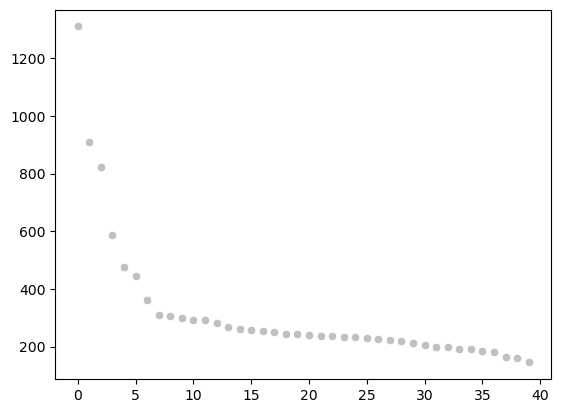

In [126]:
## Studying the dominant atac PC's

U1_init_ad, S1_init_ad, V1_init_ad = np.linalg.svd(A_wnn, full_matrices = False)
plot_svd_ad = S1_init_ad[:topk]
sns.scatterplot(data = plot_svd_ad) 
k_A = topk
U_A_adj, S_A_adj, V_A_adj = np.linalg.svd(A_wnn, full_matrices = False)

In [127]:
cov_A = (1 / A.shape[0]) * A.T @ A
L_rough = cov_A - np.identity(A.shape[1])
val, vec = np.linalg.eig(L_rough)
diag_adjust = np.diag(np.sqrt(val))
L = vec @ diag_adjust

In [128]:
val

array([270.33815849, 130.02089169, 105.83459805,  53.58635926,
        30.27985185,  34.71789908,  19.64045644,  14.19641225,
        13.94622329,   2.31724944,  13.15179176,  12.62851492,
        12.5054774 ,   3.11677839,   3.29691589,  11.46127488,
         4.15138567,  10.41641524,   4.39831237,   4.70429806,
         4.86596933,   5.33151462,   5.14700367,   5.74576815,
         9.65156374,   9.51505614,   6.22421093,   9.285034  ,
         6.62937974,   8.79951301,   6.84611555,   8.47408231,
         8.40883729,   8.181389  ,   7.10405611,   7.31972493,
         7.92649112,   7.75999746,   7.57302632,   7.63980986])

In [129]:
## Reading in atac Data

data_atac = scp.read_h5ad('cleaned_atac_reads_tea_seq.h5ad')
B_raw = data_atac.X
B_raw = pd.DataFrame(B_raw)
B_raw = B_raw.to_numpy()
B_raw = B_raw.T

## Rescaling the matrix to get 1/sqrt(n) scaling

B = B_raw / np.sqrt(B_raw.shape[0])
B = B.astype('float64')

In [130]:
B.shape

(6323, 5000)

In [131]:
## Reading in RNA Data

data_rna = scp.read_h5ad('cleaned_rna_reads_tea_seq.h5ad')
C_raw = data_rna.X
C_raw = pd.DataFrame(C_raw)
C_raw = C_raw.to_numpy()
C_raw = C_raw.T

## Rescaling the matrix to get 1/sqrt(n) scaling

C = C_raw / np.sqrt(C_raw.shape[0])
C = C.astype('float64')


In [132]:
C.shape

(6323, 2000)

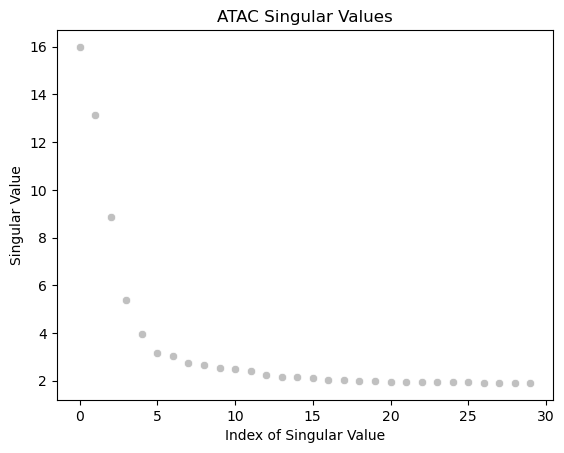

In [133]:
## Studying the dominant atac PC's

U1_init_bn, S1_init_bn, V1_init_bn = np.linalg.svd(B, full_matrices = False)
plot_svd = S1_init_bn[:30]
sns.scatterplot(data = plot_svd) 
plt.xlabel('Index of Singular Value')
plt.ylabel('Singular Value')
plt.title('ATAC Singular Values')
plt.show()


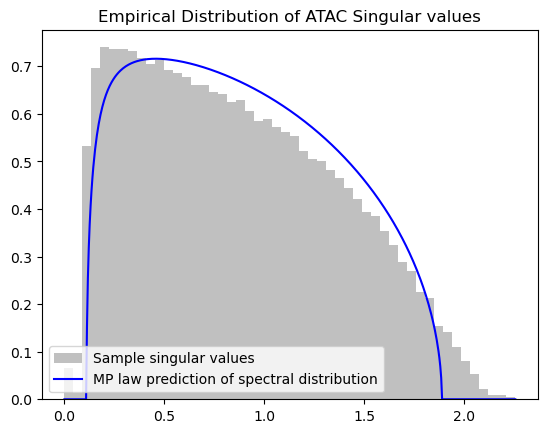

In [134]:
## Correcting for the noise variance

k_B = 15
n_features_B = B.shape[1]
n_samples_B = B.shape[0]
B_residual = B-U1_init_bn[:,:k_B] @ np.diag(S1_init_bn[:k_B]) @ V1_init_bn[:k_B,:]
tau_sq_correct_B = np.sum(B_residual**2) / n_features_B 
B_residual = B_residual/np.sqrt(tau_sq_correct_B)
U1_init_res_B, S1_init_res_B, V1_init_res_B = np.linalg.svd(B_residual, full_matrices = False)
fig, ax = plt.subplots()
sq_singular_val_B = S1_init_res_B 
shorter_side_B = min(n_samples_B, n_features_B)
ax.hist(sq_singular_val_B[:shorter_side_B], density = True, bins = 50, label = "Sample singular values")
x = np.linspace(sq_singular_val_B.min(), sq_singular_val_B.max(), num = 500)
aspect_ratio = n_features_B / n_samples_B
if aspect_ratio > 1:
    scaler = aspect_ratio
else:
    scaler = 1
ax.plot(x, scaler*np.array(sqrtMPlaw(x, n_samples_B, n_features_B)), label = "MP law prediction of spectral distribution")
ax.legend()
ax.set_title("Empirical Distribution of ATAC Singular values") 
plt.show()

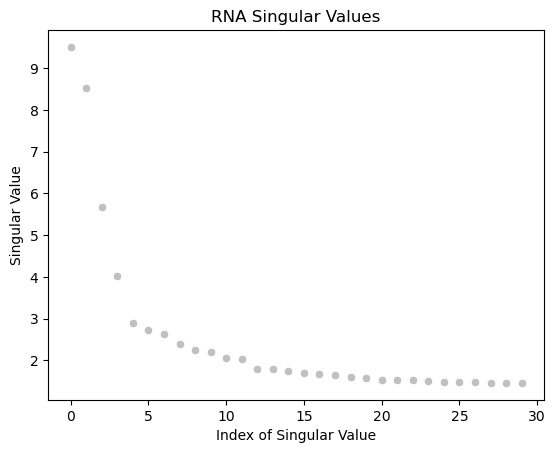

In [135]:
## Studying the dominant rna PC's

U2_init_bn, S2_init_bn, V2_init_bn = np.linalg.svd(C, full_matrices = False)
plot_svd = S2_init_bn[:30]
sns.scatterplot(data = plot_svd) 
plt.xlabel('Index of Singular Value')
plt.ylabel('Singular Value')
plt.title('RNA Singular Values')
plt.show()

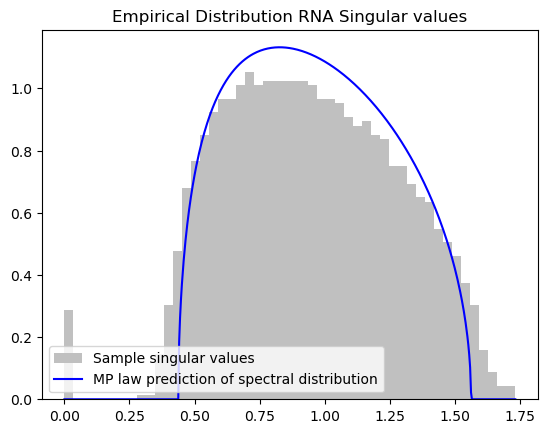

In [136]:
## Correcting for the noise variance

k_C = 20
n_features_C = C.shape[1]
n_samples_C = C.shape[0]
C_residual = C-U2_init_bn[:,:k_C] @ np.diag(S2_init_bn[:k_C]) @ V2_init_bn[:k_C,:]
tau_sq_correct_C = np.sum(C_residual**2) / n_features_C 
C_residual = C_residual/np.sqrt(tau_sq_correct_C)
U2_init_res_C, S2_init_res_C, V2_init_res_C = np.linalg.svd(C_residual, full_matrices = False)
fig, ax = plt.subplots()
sq_singular_val_C = S2_init_res_C 
shorter_side_C = min(n_samples_C, n_features_C)
ax.hist(sq_singular_val_C[:shorter_side_C], density = True, bins = 50, label = "Sample singular values")
x = np.linspace(sq_singular_val_C.min(), sq_singular_val_C.max(), num = 500)
aspect_ratio = n_features_C / n_samples_C
if aspect_ratio > 1:
    scaler = aspect_ratio
else:
    scaler = 1
ax.plot(x, scaler*np.array(sqrtMPlaw(x, n_samples_C, n_features_C)), label = "MP law prediction of spectral distribution")
ax.legend()
ax.set_title("Empirical Distribution RNA Singular values") 
plt.show()

In [137]:
A_reduced = A
B_reduced = B / np.sqrt(tau_sq_correct_B)
C_reduced = C / np.sqrt(tau_sq_correct_C)

In [138]:
# Read metadata: assume first column is some ID, labels in the rest
meta = pd.read_csv("cleaned_cell_labels_meta_tea_seq.csv", index_col=0)

# Convert to numpy (this should now be just the labels, numeric or string)
meta = meta.to_numpy()

# Flatten in C order
labels = meta.flatten(order="C")

In [139]:
seed = 10

# Atlas Building

In [140]:
## Aspect Ratios

gamma_1 = B_reduced.shape[1]/B_reduced.shape[0]
gamma_2 = C_reduced.shape[1]/C_reduced.shape[0]

In [141]:
## Compute Singular Value Decomposition of B

k = k_B

U1_init, S1_init, V1_init = np.linalg.svd(B_reduced, full_matrices = False)
s_hat = S1_init[0:k] / np.sqrt(gamma_1)
s_hat = _convert_singular_val(s_hat,gamma_1)
S_hat = np.diag(s_hat)

sigma_x = (1 + gamma_1 * s_hat ** 2) / (gamma_1 * s_hat ** 2 * (s_hat ** 2 + 1))
mu_x = np.sqrt(1 - sigma_x)
sigmabar_x = (1 + s_hat ** 2) / (s_hat ** 2 * (gamma_1 * s_hat ** 2 + 1))
mubar_x = np.sqrt(1 - sigmabar_x)

# initialize M0 and Q0 for X

M_0_x = np.diag(mu_x)
Sigma_0_x = np.diag(sigma_x)
M_bar_x = np.diag(mubar_x)
Sigma_bar_x = np.diag(sigmabar_x)

In [142]:
## Compute Singular Value Decomposition of B for WNN

k_wnn = 50

U1_init_wnn, S1_init_wnn, V1_init_wnn = np.linalg.svd(B_reduced, full_matrices = False)
s_hat_wnn = S1_init_wnn[:k_wnn] / np.sqrt(gamma_1)
s_hat = _convert_singular_val(s_hat,gamma_1) 
S_hat_wnn = np.diag(s_hat_wnn)

sigma_x_wnn = (1 + gamma_1 * s_hat_wnn ** 2) / (gamma_1 * s_hat_wnn ** 2 * (s_hat_wnn ** 2 + 1))
mu_x_wnn = np.sqrt(1 - sigma_x_wnn)
sigmabar_x_wnn = (1 + s_hat_wnn ** 2) / (s_hat_wnn ** 2 * (gamma_1 * s_hat_wnn ** 2 + 1))
mubar_x_wnn = np.sqrt(1 - sigmabar_x_wnn)

# initialize M0 and Q0 for X

M_0_x_wnn = np.diag(mu_x_wnn)
Sigma_0_x_wnn = np.diag(sigma_x_wnn)
M_bar_x_wnn = np.diag(mubar_x_wnn)
Sigma_bar_x_wnn = np.diag(sigmabar_x_wnn)

In [143]:
## Compute Singular Value Decomposition of C

k_2 = k_C

U2_init, S2_init, V2_init = np.linalg.svd(C_reduced, full_matrices = False)
s_tilde = S2_init[0:k_2] / np.sqrt(gamma_2)
s_tilde = _convert_singular_val(s_tilde,gamma_2) 
S_tilde = np.diag(s_tilde)

sigma_y = (1 + gamma_2 * s_tilde ** 2) / (gamma_2 * s_tilde ** 2 * (s_tilde ** 2 + 1))
mu_y = np.sqrt(1 - sigma_y)
sigmabar_y = (1 + s_tilde ** 2) / (s_tilde ** 2 * (gamma_2 * s_tilde ** 2 + 1))
mubar_y = np.sqrt(1 - sigmabar_y)

# initialize M0 and Q0 for Y

M_0_y = np.diag(mu_y)
Sigma_0_y = np.diag(sigma_y)
M_bar_y = np.diag(mubar_y)
Sigma_bar_y = np.diag(sigmabar_y)

In [144]:
## Compute Singular Value Decomposition of C for WNN

k_2_wnn = 50

U2_init_wnn, S2_init_wnn, V2_init_wnn = np.linalg.svd(C_reduced, full_matrices = False)
s_tilde_wnn = S2_init_wnn[0:k_2_wnn] / np.sqrt(gamma_2)
s_tilde = _convert_singular_val(s_tilde,gamma_2) 
S_tilde_wnn = np.diag(s_tilde_wnn)

sigma_y_wnn = (1 + gamma_2 * s_tilde_wnn ** 2) / (gamma_2 * s_tilde_wnn ** 2 * (s_tilde_wnn ** 2 + 1))
mu_y_wnn = np.sqrt(1 - sigma_y_wnn)
sigmabar_y_wnn = (1 + s_tilde_wnn ** 2) / (s_tilde_wnn ** 2 * (gamma_2 * s_tilde_wnn ** 2 + 1))
mubar_y_wnn = np.sqrt(1 - sigmabar_y_wnn)

# initialize M0 and Q0 for Y

M_0_y_wnn = np.diag(mu_y_wnn)
Sigma_0_y_wnn = np.diag(sigma_y_wnn)
M_bar_y_wnn = np.diag(mubar_y_wnn)
Sigma_bar_y_wnn = np.diag(sigmabar_y_wnn)

In [145]:
n = B_reduced.shape[0]; p_1 = B_reduced.shape[1]; p_2 = C_reduced.shape[1]

In [146]:
## Scaling of the singular vectors of B and C

F_x = np.sqrt(n) * U1_init[:,:k]
G_x = np.sqrt(p_1) * V1_init.T[:,:k]

F_y = np.sqrt(n) * U2_init[:,:k_2]
G_y = np.sqrt(p_2) * V2_init.T[:,:k_2]

G = G_x
U_x_t = F_x @ sp.linalg.sqrtm(Sigma_0_x)

Gbar = G_y
U_y_t = F_y @ sp.linalg.sqrtm(Sigma_0_y)

In [147]:
## Scaling of the singular vectors of B and C for wnn

F_x_wnn = np.sqrt(n) * U1_init_wnn[:,:k_wnn]
G_x_wnn = np.sqrt(p_1) * V1_init_wnn.T[:,:k_wnn]

F_y_wnn = np.sqrt(n) * U2_init_wnn[:,:k_2_wnn]
G_y_wnn = np.sqrt(p_2) * V2_init_wnn.T[:,:k_2_wnn]

G_wnn = G_x_wnn
U_x_t_wnn = F_x_wnn @ sp.linalg.sqrtm(Sigma_0_x_wnn)

Gbar_wnn = G_y_wnn
U_y_t_wnn = F_y_wnn @ sp.linalg.sqrtm(Sigma_0_y_wnn)

In [148]:
Sigma_0_x_wnn.shape

(50, 50)

In [149]:
## Store Raw PC's to run WNN

pc_x_for_seurat_with_pred = pd.DataFrame(F_x_wnn)
pc_x_for_seurat_with_pred.to_csv('pc_atac_for_tea_seq_analysis_job_talk.csv')
pc_y_for_seurat_with_pred = pd.DataFrame(F_y_wnn)
pc_y_for_seurat_with_pred.to_csv('pc_rna_for_tea_seq_analysis_job_talk.csv')

In [150]:
pc_z_for_seurat_with_pred = pd.DataFrame(U_A_adj[:,:40] @ np.diag(S_A_adj[:40]) )
pc_z_for_seurat_with_pred.to_csv('pc_adt_for_tea_seq_analysis_job_talk.csv')

In [151]:
# Protein component

F_z = A_reduced
U_z_t = F_z @ np.linalg.inv(L)

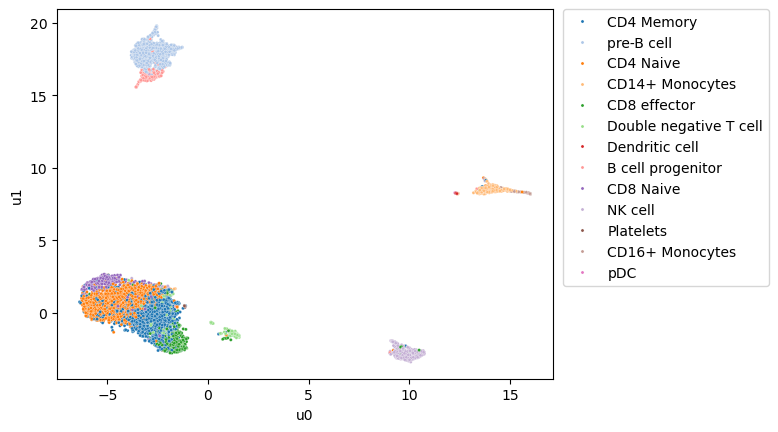

In [152]:
## Visulize UMAP without Data Integration

joint_embedding_PC = np.concatenate((U_z_t,U_x_t,U_y_t),axis=1)
u_pc_embedding = umap.UMAP().fit_transform(
        joint_embedding_PC )
umap_data_PC = pd.DataFrame({'u0': u_pc_embedding[:, 0], 'u1': u_pc_embedding[:, 1], 'label': labels})
sns.scatterplot(data=umap_data_PC, x='u0', y='u1', hue='label', palette= 'tab20', s = 5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [153]:
## Determine the support
Sigma_bar_z = np.eye(L.shape[0])

n_clusters_u = int(np.round(np.cbrt(n)))
n_clusters_v_1 = int(np.round(np.cbrt(p_1)))
n_clusters_v_2 = int(np.round(np.cbrt(p_2)))

#n_clusters_u = 25
#n_clusters_v_1 = 20
#n_clusters_v_2 = 20

data_prior_u = np.concatenate((F_x,F_y,F_z), axis=1)
means_prior_u = sp.linalg.block_diag(M_bar_x, M_bar_y, L)
cov_prior_u = sp.linalg.block_diag(Sigma_bar_x, Sigma_bar_y, Sigma_bar_z)

data_prior_v_x = G_x
means_prior_v_x = M_0_x
cov_prior_v_x = Sigma_0_x

data_prior_v_y = G_y
means_prior_v_y = M_0_y
cov_prior_v_y = Sigma_0_y


### Model selection for GMM priors of right singular vectors
We address the referee's concern about the unique choice of number of clusters by fitting GMMs for a grid of cluster numbers and selecting the best model using BIC.

In [154]:
# Example usage for v_x and v_y priors
k_max_v_1 = max(10, int(np.cbrt(p_1)))
k_max_v_2 = max(10, int(np.cbrt(p_2)))

best_k_v_1, best_gmm_v_1, bics_v_1 = bic_gmm_grid_search(data_prior_v_x, k_min=1, k_max=k_max_v_1, random_state=seed)
best_k_v_2, best_gmm_v_2, bics_v_2 = bic_gmm_grid_search(data_prior_v_y, k_min=1, k_max=k_max_v_2, random_state=seed)

mean_prior_comp_v_x = best_gmm_v_1.means_
cov_prior_comp_v_x = best_gmm_v_1.covariances_
weights_prior_comp_v_x = best_gmm_v_1.weights_

mean_prior_comp_v_y = best_gmm_v_2.means_
cov_prior_comp_v_y = best_gmm_v_2.covariances_
weights_prior_comp_v_y = best_gmm_v_2.weights_

In [155]:
k_max_v_1, k_max_v_2

(17, 12)

In [156]:
# Example usage for v_x and v_y priors
k_max_u = max(10, int(np.cbrt(n)))

best_k_u, best_gmm_u, bics_u = bic_gmm_grid_search(data_prior_u, k_min=1, k_max=k_max_u, random_state=seed)

mean_prior_comp_u = best_gmm_u.means_
cov_prior_comp_u = best_gmm_u.covariances_
weights_prior_comp_u = best_gmm_u.weights_

In [157]:
best_k_u, best_k_v_1, best_k_v_2

(np.int64(4), np.int64(11), np.int64(6))

In [158]:
## NPMLE of the priors of right singular vectors

#mean_prior_comp_v_x, cov_prior_comp_v_x, weights_prior_comp_v_x = fit_gmm(data_prior_v_x, n_clusters_v_1, means_prior_v_x, cov_prior_v_x, seed)
#mean_prior_comp_v_y, cov_prior_comp_v_y, weights_prior_comp_v_y = fit_gmm(data_prior_v_y, n_clusters_v_2, means_prior_v_y, cov_prior_v_y, seed)

In [159]:
## NPMLE of the priors of left singular vectors
#mean_prior_comp_u, cov_prior_comp_u, weights_prior_comp_u = fit_gmm(data_prior_u, n_clusters_u, means_prior_u, cov_prior_u, seed)

In [160]:
U_z_t.shape

(6323, 40)

# AMP Iteration

In [161]:
k = k 

In [162]:
# iterative refinement

max_iter = 15

#Uerrors = np.zeros((max_iter, 1))
#Verrors = np.zeros((max_iter, 1))

M_x = np.array([M_0_x])
M_y = np.array([M_0_y])
Sigma_x = np.array([Sigma_0_x])
Sigma_y = np.array([Sigma_0_y])

for t in range(max_iter):
    
    # Denoising the right singular vectors
    
    V_x_t = denoise_gmm(G, mean_prior_comp_v_x, cov_prior_comp_v_x, M_x, Sigma_x, weights_prior_comp_v_x)
    V_y_t = denoise_gmm(Gbar, mean_prior_comp_v_y, cov_prior_comp_v_y, M_y, Sigma_y, weights_prior_comp_v_y)
    
    #print(V_x_t[0:5,0:5]); print(V_y_t[0:5,0:5])
    
    # Compute the Jacobians
    J_x = np.mean(ddenoise_gmm(G, mean_prior_comp_v_x, cov_prior_comp_v_x, M_x, Sigma_x, weights_prior_comp_v_x), axis=0)
    J_y = np.mean(ddenoise_gmm(Gbar, mean_prior_comp_v_y, cov_prior_comp_v_y, M_y, Sigma_y, weights_prior_comp_v_y), axis=0)
    
    # Substract the onsager terms
    F = B_reduced.dot(V_x_t) - gamma_1 * U_x_t.dot(J_x.T)
    Fbar = C_reduced.dot(V_y_t) - gamma_2 * U_y_t.dot(J_y.T)
    
    # Update State Evolution Parameters
    Sigmabar_x = (V_x_t.T @ V_x_t) / n
    if np.linalg.det(Sigmabar_x) <= 2.7e-05:
        np.fill_diagonal(Sigmabar_x, Sigmabar_x.diagonal() + np.finfo('float32').eps)
    Mbar_x = Sigmabar_x * s_hat
    Sigmabar_y = (V_y_t.T @ V_y_t) / n
    if np.linalg.det(Sigmabar_y) <= 2.7e-05:
        np.fill_diagonal(Sigmabar_y, Sigmabar_y.diagonal() + np.finfo('float32').eps)
    Mbar_y = Sigmabar_y * s_tilde

    Mbar = np.array([Mbar_x, Mbar_y, L], dtype=object)
    Sigmabar = np.array([Sigmabar_x, Sigmabar_y, Sigma_bar_z], dtype=object)
    F_comb = np.concatenate((F, Fbar, F_z), axis=1)

    # Denoise left singular vectors in a orchestrated manner
    U_x_t = denoise_gmm(F_comb, mean_prior_comp_u, cov_prior_comp_u, Mbar, Sigmabar, weights_prior_comp_u)[:,:k]
    U_y_t = denoise_gmm(F_comb, mean_prior_comp_u, cov_prior_comp_u, Mbar, Sigmabar, weights_prior_comp_u)[:,k:(k+k_2)]
    U_z_t = denoise_gmm(F_comb, mean_prior_comp_u, cov_prior_comp_u, Mbar, Sigmabar, weights_prior_comp_u)[:,(k+k_2):]
    
    J_comb = ddenoise_gmm(F_comb, mean_prior_comp_u, cov_prior_comp_u, Mbar, Sigmabar, weights_prior_comp_u)
    
    # Compute the Jacobians
    J_1 = np.mean(J_comb[:,:k,:k], axis = 0)
    J_2 = np.mean(J_comb[:,k:(k+k_2),k:(k+k_2)], axis = 0)
    
    # Substract the onsager terms
    G = (B_reduced.T).dot(U_x_t) - V_x_t.dot(J_1.T)
    Gbar = (C_reduced.T).dot(U_y_t) - V_y_t.dot(J_2.T)
    
    # Update State Evolution Parameters
    Sigma_x = (U_x_t.T @ U_x_t) / n
    if np.linalg.det(Sigma_x) <= 2.7e-05:
        np.fill_diagonal(Sigma_x, Sigma_x.diagonal() + np.finfo('float32').eps)
    M_x = Sigma_x * s_hat
    Sigma_y = (U_y_t.T @ U_y_t) / n
    if np.linalg.det(Sigma_y) <= 2.7e-05:
        np.fill_diagonal(Sigma_y, Sigma_y.diagonal() + np.finfo('float32').eps)
    M_y = Sigma_y * s_tilde

    M_x = np.array([M_x])
    M_y = np.array([M_y])
    Sigma_x = np.array([Sigma_x])
    Sigma_y = np.array([Sigma_y])
    
    print(f"The current iteration is {t}")
   
    ## Update the priors and the support if needed

    ### pi_single_v_x = estimate_prior_single(G, supp_x_v, M_x, Sigma_x, 10)
    ### pi_single_v_y = estimate_prior_single(Gbar, supp_y_v, M_y, Sigma_y, 10)
    ### pi_joint_u = estimate_prior_joint(F, Fbar, supp_x_u, supp_y_u, Mbar_x, Mbar_y, Sigmabar_x, Sigmabar_y, 10)
    ### supp_x_u = extract_support(F, n_clusters_u, Mbar_x)
    ### supp_y_u = extract_support(Fbar, n_clusters_u, Mbar_y)

    ### supp_x_v = extract_support(G, n_clusters_u, M_x)
    ### supp_y_v = extract_support(Gbar, n_clusters_u, M_y)

The current iteration is 0
The current iteration is 1
The current iteration is 2
The current iteration is 3
The current iteration is 4
The current iteration is 5
The current iteration is 6
The current iteration is 7
The current iteration is 8
The current iteration is 9
The current iteration is 10
The current iteration is 11
The current iteration is 12
The current iteration is 13
The current iteration is 14


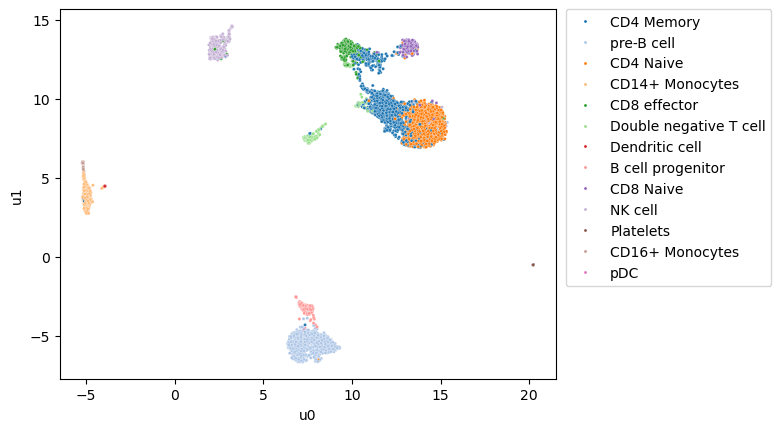

In [163]:
joint_embedding_amp = np.concatenate((U_z_t,U_x_t,U_y_t),axis=1)
amp_for_pred = pd.DataFrame(joint_embedding_amp)
amp_for_pred.to_csv('amp_for_prediction_job_talk_gmm.csv')
u_joint_embedding = umap.UMAP().fit_transform(
        joint_embedding_amp)
umap_data = pd.DataFrame({'u0': u_joint_embedding[:, 0], 'u1': u_joint_embedding[:, 1], 'label': labels})
sns.scatterplot(data=umap_data, x='u0', y='u1', hue='label', palette= 'tab20', s = 5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [164]:
F.shape

(6323, 15)

In [165]:
joint_embedding_amp.shape

(6323, 75)